# Create odor maps of MOB data

Create odormaps sorted by animals and odormaps sorted by odors

First we need to set the paths to the code and the data. Update this according to your environment.

In [1]:
import os
import sys
curdir = os.path.abspath(os.path.curdir)
toplevelpath = os.path.abspath(os.path.join(os.path.curdir, os.path.pardir))
sys.path.append(os.path.join(curdir,'FUImaging'))
# on jan's environment
# FUImaging_path = '/home/jan/Dokumente/Code/FUImaging/'
# data_path = '/media/jan/BackupWork/Documents/NewAnalysis/' 
# on micha's environment
#FUImaging_path = os.path.join(os.environ['HOME'], 'Projects','MouseBulb', 'code','FUImaging')
#sys.path.append(FUImaging_path)
#basepath = os.path.join(os.environ['HOME'], 'Projects','MouseBulb', "HartwigData")

In [2]:
import os, glob, csv, json, pickle
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

from regnmf import ImageAnalysisComponents as ia

### Specify parameter

In [3]:
stim_cut = (8,12) #frames averagaed for odor maps [(3,5) for IOS prepro, (8,12) fro sph]
draw_sphrois = True #False #
filename = 'sph_meas'
sort_by_name = True # Display odor maps according to odor identity. Else in order of measurement

#basepath = os.path.join('/home/jan/Dokumente/MOBData/')
basepath = os.path.realpath('../glomcentric_data')
datapath = os.path.join(basepath, 'MOBconverted')
savepath_vis = os.path.join(basepath,'Vis')
savepath_animalsorted = os.path.join(basepath,'Vis','Measurements')
savepath_odorsorted = os.path.join(basepath,'Vis','Odormaps')
datadict_path = os.path.join(basepath, 'DataDicts')

cas2name = {l[0]:l[1] for l in csv.reader(open(os.path.join(datadict_path,'Name2MomCas.tab')),  delimiter='\t')}
animals = [ani for ani in os.listdir(datapath) if 'FRV' in ani]

## Generate odormaps for each animal across odors

In [4]:
animals = animals[5:]

In [5]:
for animal in np.sort(animals):
    
    bgpath = os.path.join(datapath, animal, 'bg.png')
    if os.path.exists(bgpath):
        bg = Image.open(bgpath)
        bg = bg.convert('L')
    else:
        bgpath=False
    
    fileloc = os.path.join(datapath, animal, filename)
    ts = ia.TimeSeries()
    ts.load(fileloc)
    ts = ia.TrialMean()(ia.CutOut(stim_cut)(ts))
    if sort_by_name:
        order_ix = np.argsort(ts.label_stimuli)
        ts = ia.SelectTrials()(ts, order_ix)
    
    if bgpath:
        bg = bg.resize(ts.shape[::-1])
        bg = np.asarray(bg)
    
    if draw_sphrois:
        rois = ia.TimeSeries()
        rois.load(os.path.join(datapath, animal, 'rois'))
    
    rows = np.ceil((len(ts.label_stimuli)+1)/5.)
    fig = plt.figure(figsize=(10, 1.5*int(rows)))
    plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.95)
    
    if bgpath:
        ax = fig.add_subplot(rows, 5, 1)
        ax.imshow(bg, origin='upper', cmap=plt.cm.bone)
        ax.set_xticks([])
        ax.set_yticks([])

    for oix, odormap in enumerate(ts.shaped2D()):
        ax = fig.add_subplot(rows, 5, oix+2)
        amax = np.percentile(np.abs(odormap),99.8)
        ax.imshow(odormap, vmin=-amax, vmax=amax, interpolation='none', origin='upper')
        if draw_sphrois:
            for roi in rois.shaped2D():
                ax.contour(roi, [0.5], colors=['w'])
        else:
            ax.contour(bg, [np.percentile(bg.flatten(),99.5)], colors=['w'])
        ax.set_xticks([])
        ax.set_yticks([])
        stim_name = ts.label_stimuli[oix].split('_')
        title = cas2name[stim_name[0]]
        if len(stim_name)>1:
            title = title + ' (%s)'%';'.join(stim_name[1:])
        
        ax.set_title(title, size=5)
        ax.set_ylabel('id:%s, max:%.2f'%(stim_name[0],amax), size=5)
    if not os.path.exists(savepath_animalsorted):
        os.makedirs(savepath_animalsorted)
    fig.savefig(os.path.join(savepath_animalsorted, animal+'.pdf'))
    plt.close('all')   

<ipython-input-5-5da3e0586bdc>:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(rows, 5, 1)
<ipython-input-5-5da3e0586bdc>:37: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(rows, 5, oix+2)
<ipython-input-5-5da3e0586bdc>:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(rows, 5, 1)
<ipython-input-5-5da3e0586bdc>:37: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(rows, 5, oix+2)
<ipython-input-5-5da3e0586bdc>:31: MatplotlibDeprecationWarning: Pas

## Generate odormaps for each odor across animals

Define function to clear stimuli labels. Thus it determines which stimuli are grouped together. Currently remove 'rechts'/'links' labels, as they correspond to syringe used. And '50grad' as there is no visible effect

In [6]:
to_remove = ['rechts','links','re','li','50grad']

def clear_label(label):
    if '_' in label:
        label_split = label.split('_')
        for remove in set(to_remove).intersection(label_split):
            label_split.remove(remove)
        label = '_'.join(label_split)
    return label   

Define function to convert CAS stimuli names to Odor stimuli names

In [7]:
def convert_cas2name(cas_stim):
    stim_parts = cas_stim.split('_')
    title = cas2name[stim_parts[0]]
    if len(stim_parts)>1:
        title = title + ' (%s)'%';'.join(stim_parts[1:])
    return title

#### collect odormaps

In [8]:
odormaps = defaultdict(list)
for animal in np.sort(animals):
       
    fileloc = os.path.join(datapath, animal, filename)
    ts = ia.TimeSeries()
    ts.load(fileloc)
    ts.label_stimuli = [clear_label(i) for i in ts.label_stimuli]
    ts = ia.SingleSampleResponse()(ia.TrialMean()(ia.CutOut(stim_cut)(ts)))
       
    for oix, odormap in enumerate(ts.shaped2D()):
        if 'l' in ts.name: odormap = odormap[::-1] #mirror image if from left bulb 
        odormaps[ts.label_stimuli[oix]].append((odormap, ts.name))

#### Draw odormaps

In [9]:
for odor, data in odormaps.items():
    
    title = convert_cas2name(odor)  
    
    rows = int(np.ceil(len(data)/5.))
    fig = plt.figure(figsize=(10, 1.5*rows))
    plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.8)
    
    
    for oix, (odormap, label) in enumerate(data):
        ax = fig.add_subplot(rows, 5, oix+1)
        amax = np.percentile(np.abs(odormap),99.8)
        ax.imshow(odormap, vmin=-amax, vmax=amax, interpolation='none', origin='upper')

        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_title(label, size=5)
        ax.set_ylabel('max:%.2f'%amax, size=5)
        
    fig.suptitle(title)
    if not os.path.exists(savepath_odorsorted):
        os.makedirs(savepath_odorsorted)
    fig.savefig(os.path.join(savepath_odorsorted, title + '.pdf'))
    plt.close('all')   

## Generate overview matrix of animals and odors

#### Create measurement matrix, one dimension animals (sorted by data) and the other dimesion odors (sorted by first measurement)

In [10]:
odors = list(odormaps.keys())
animals = [i.split('_')[0] for i in np.sort(animals)]

#collect first appearence of odor
min_animal = []
for odor in odors:
    min_animal.append(np.sort([o[1].split('_')[0] for o in odormaps[odor]])[0])

# sort odors for first appearence
odors = [odors[i] for i in np.argsort(min_animal)]

#create existence matrix odors x animals
matrix = []
for odor in odors:
    temp = np.zeros(len(animals))
    for animal in [o[1].split('_')[0] for o in odormaps[odor]]:
        temp[animals.index(animal)] = 1
    matrix.append(temp)
matrix = np.array(matrix)

#### Assing each odor a heritage (i.e. round of iteration)

Read in csv file with heritage data

In [11]:
csvreader =  csv.reader(open(os.path.join(datadict_path, 'iterations.tab')),  delimiter='\t')
headings = next(csvreader)[2:]
cas2iteration = {l[0]:l[2:] for l in csvreader}

Extract first occurence for all odors from heritage dictionary. If an odor is not included in the heritage dictionary, it is regarded as an compound odor  

In [12]:
verbose = 0 #set True to print warnings

def first_entry_in_list(mylist, headings):
    for ix, entry in enumerate(mylist):
        if entry:
            return headings[ix]
    return 'train'

iteration = []
for odor in odors:
    odor_parts = odor.split('_')
    odor = odor_parts[0].strip()
    if 'o' in odor_parts:
        odor_parts.remove('o')
    if len(odor_parts)<2 and (odor in cas2iteration):
        iteration.append(first_entry_in_list(cas2iteration[odor], headings))
    else:
        iteration.append('compound')
        if verbose:
            print('Warning: no entry for %s, marked as compound'%('_'.join(odor_parts)))
iteration = np.array(iteration)

Plot the measurement matrix. Color each odor according to its heritage.

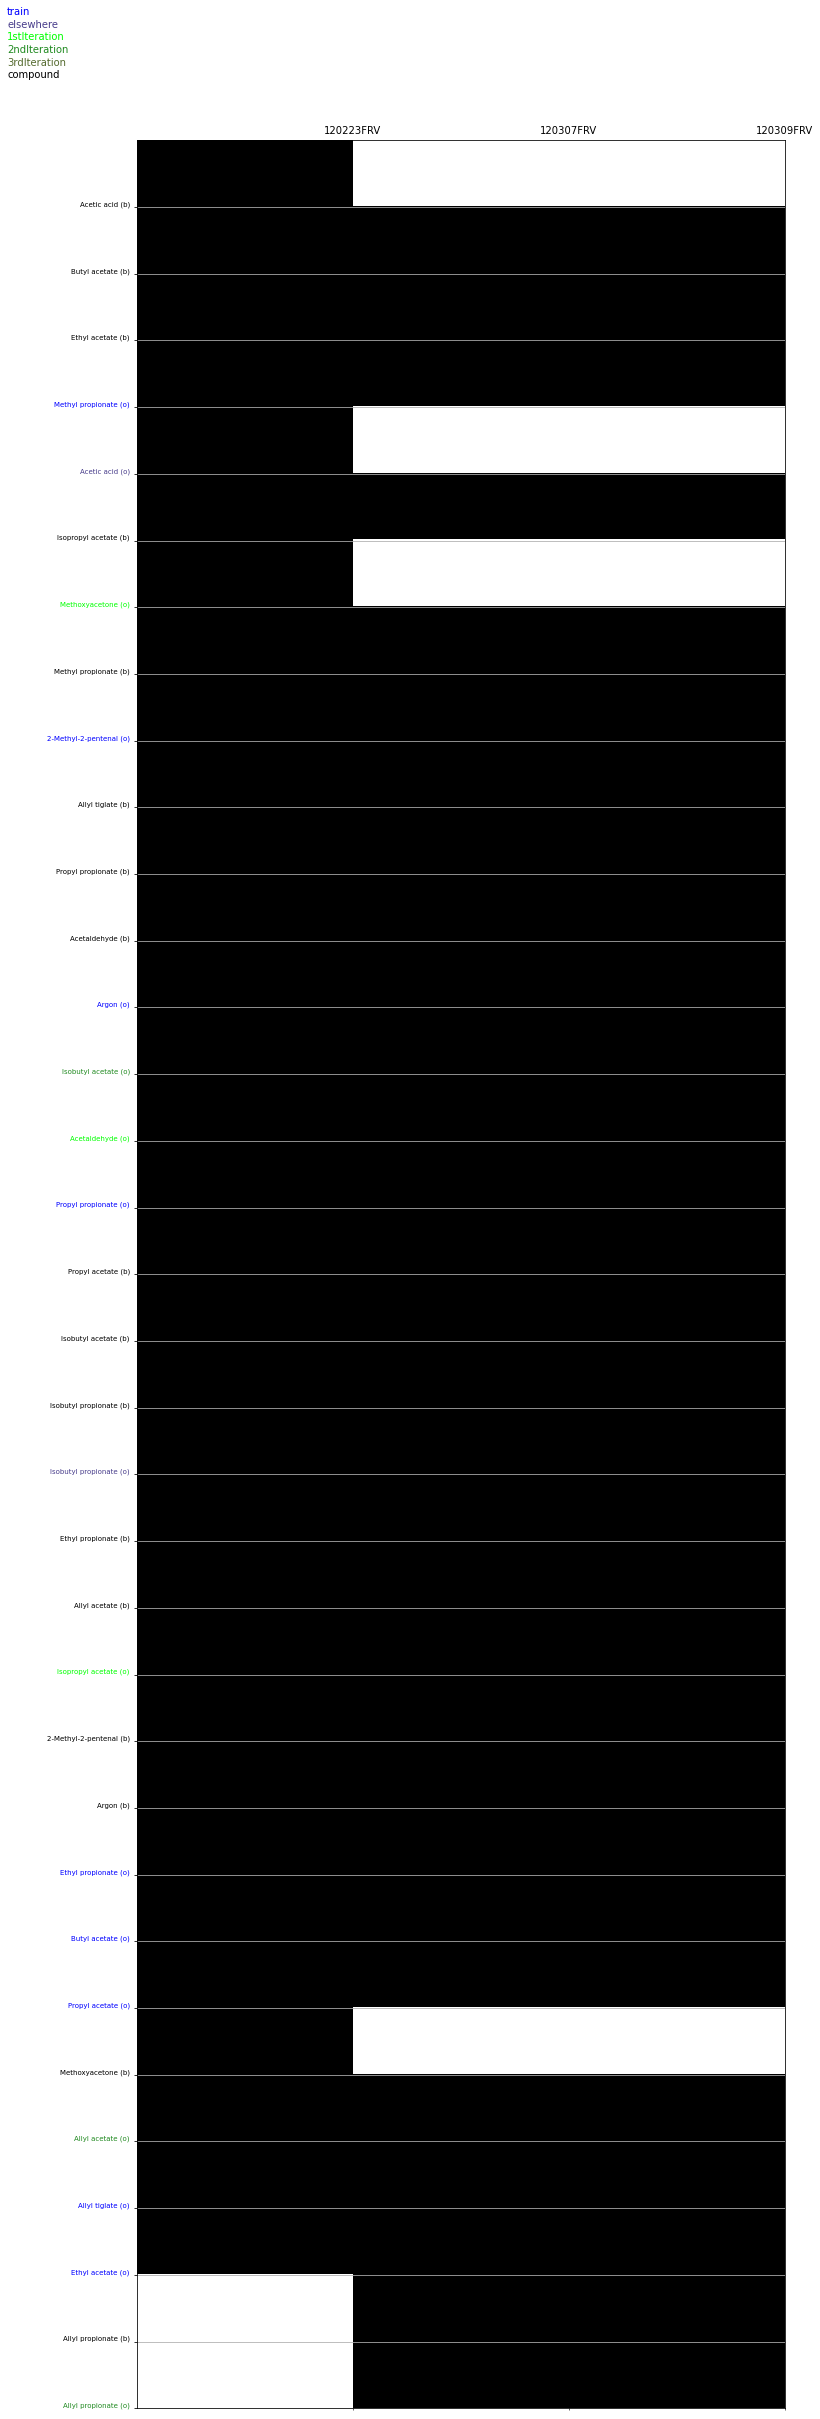

In [13]:
heritagecolors = {'train' : 'b', 'elsewhere': np.array((72,61,139))/255., '1stIteration': np.array((0,255,0))/255.,
              '2ndIteration': np.array((34,139,34))/255., '3rdIteration': np.array((85,107,47))/255., 'compound':'k'}

fig = plt.figure(figsize=(12, 35))
ax = fig.add_axes([0.2,0.02,0.75,0.9])

ax.imshow(matrix, interpolation='none', aspect='auto', cmap=plt.cm.binary)
ax.set_yticks(np.arange(matrix.shape[0])+0.5)
ax.set_yticklabels([convert_cas2name(o) for o in odors], size=7, va='bottom')
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=True)
ax.xaxis.set_tick_params('minor', labelbottom=False, labeltop=True)
ax.set_xticklabels(animals, size=7, rotation='90', ha='right', minor=True)
for ix, tick in enumerate(ax.yaxis.get_ticklabels()):
    tick.set_color(heritagecolors[iteration[ix]])
ax.set_xticks(np.arange(5,matrix.shape[1],5)+0.5)
ax.set_xticklabels([])
ax.grid()

for ix, (label, color) in enumerate(heritagecolors.items()):
    fig.text(0.05, 0.97-ix*0.005, label, color=color, ha='left', size=10)
    

fig.savefig(os.path.join(savepath_vis, 'Measurements.pdf'))
plt.show()